In [32]:
# Import tools: pandas, numpy, seaborn, matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Your code here
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [10, 7]

In [33]:
# Read data sales_train.csv
sales = pd.read_csv('train.csv')

In [34]:
# Show first 5 rows
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [35]:
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d')

In [36]:
# Show first 5 rows again
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [37]:
# Set date as index
sales = sales.set_index('Date')# Your code here

# Sort data base on index
sales.sort_index
# group our data with "pd.Grouper(freq='M')" and sum
# save result in sales_m
sales_m = sales.groupby(pd.Grouper(freq='M')).sum()

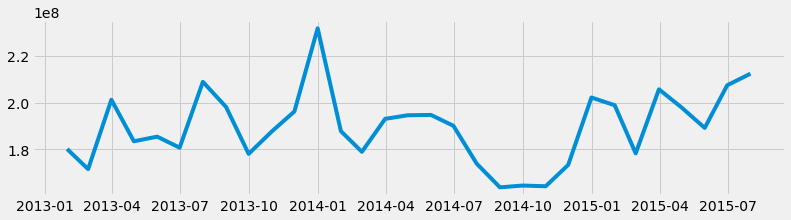

In [39]:
plt.figure(figsize=(12,3))

plt.plot(sales_m.index.values,sales_m['Sales'])

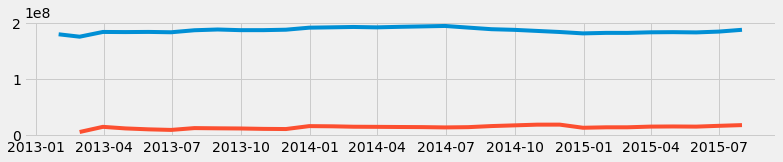

In [43]:
# Using pd.series.rolling to calculate mean and std for Sales series with window=12
# plot mean and std values
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
plt.figure(figsize=(12,2))
plt.plot(sales_m['Sales'].rolling(12, min_periods=1).mean())
plt.plot(sales_m['Sales'].rolling(12, min_periods=1).std())


Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

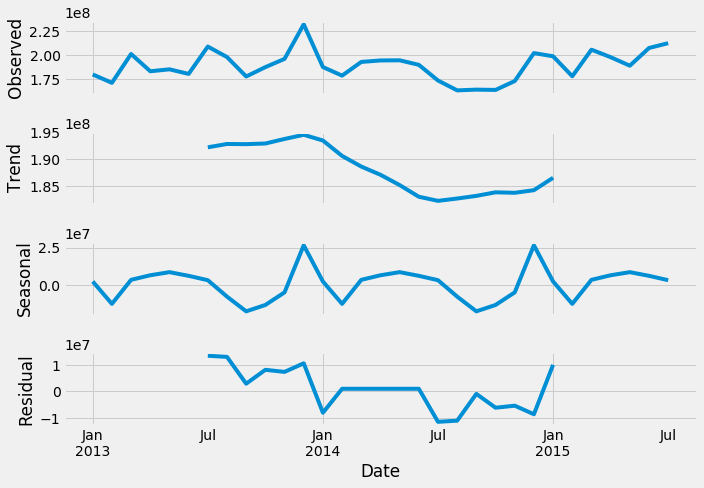

In [45]:
# Decompose item_cnt_day with freq=12, model='additive'
res = seasonal_decompose(sales_m['Sales'], model='additive', freq=12)
fig = res.plot();

In [46]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [47]:
# Let's test with original timeseries
test_stationarity(sales_m['Sales'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.544365
p-value                         0.006918
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


**What is the value of p-value?**
If it's greater than  0.05, we cannot reject that the time series is not stationary

In [48]:
# How about we try to de seasonalization our series
# Using diff with periods is 12, the same with season that we can capture from figure
# Hint: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html
sales_m_seasonalization = pd.Series(sales_m['Sales']).diff(periods=12).dropna()
test_stationarity(sales_m_seasonalization)

Results of Dickey-Fuller Test:
Test Statistic                  0.000000
p-value                         0.958532
#Lags Used                      8.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [49]:
# Let use diff series with periods is 12 for further steps. Save results in "ts" variable
ts = pd.Series(sales_m['Sales']).diff(periods=12).dropna()

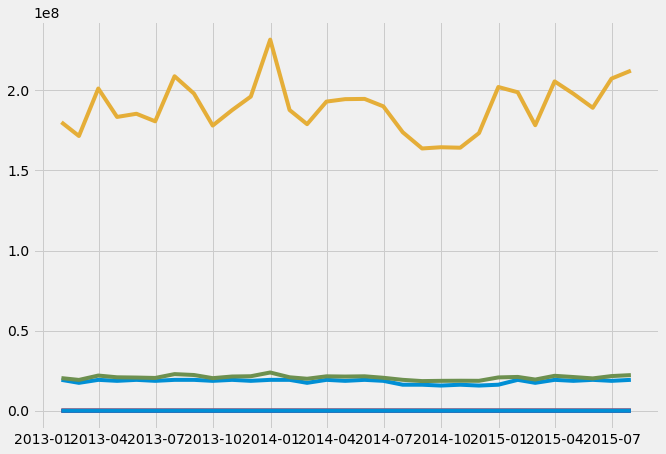

In [50]:
# Let plot and take a look at our series after de-seasonalization
# Your code here
plt.plot(sales_m)

In [26]:
from statsmodels.tsa.arima_model import ARMA

best_aic = np.inf
best_order = None
best_model = None

rng = range(15)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            # Create and train ARMA model with order=(i, j)
            model = ARMA(ts, order=(i, j)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

AIC: 692.23 | order: (1, 0)


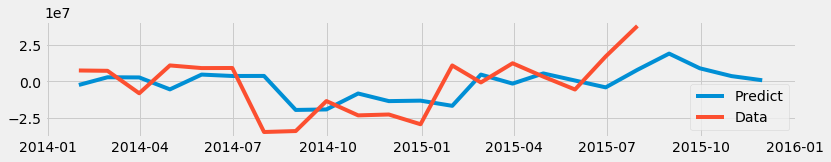

In [64]:
# Let's plot actual and predict values
# Your code here
plt.figure(figsize=(12,2))
plt.plot(best_model.predict(start = 0, end = 22), label = 'Predict')
plt.plot(ts, label = 'Data')
plt.legend()